https://pypi.python.org/pypi/pyoctree

In [1]:
%pylab inline
import plot_surf_stat_map_3 as plot_surf
import seaborn as sns
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import vtk

In [3]:
# Open mesh in ply format
def open_ply(filepath):
    import numpy
    f=open(filepath,'r');
    i=0;
    ip=0;
    it=0;
    np=0;
    nt=0;
    for str in f:
        i+=1;
        arr=str.split(" ");
        if(arr[0]=="element" and arr[1]=="vertex"):
            np=int(arr[2]);
            p=numpy.zeros((np,3));
        elif(arr[0]=="element" and arr[1]=="face"):
            nt=int(arr[2]);
            t=numpy.zeros((nt,3));
        elif(i>=11 and i<11+np):
            p[ip,0]=float(arr[0]);
            p[ip,1]=float(arr[1]);
            p[ip,2]=float(arr[2]);
            ip+=1;
        elif(i>=11+np and i<11+np+nt):
            t[it,0]=int(arr[1]);
            t[it,1]=int(arr[2]);
            t[it,2]=int(arr[3]);
            it+=1;
    mesh={};
    mesh["np"]=np;
    mesh["nt"]=nt;
    mesh["p"]=p;
    mesh["t"]=t;
    return mesh;

In [4]:
# find the node which is the closest to the given endpoint and return its id and distance to the endpoint
def findClosestNode(ep,tree):
    import scipy.spatial.distance as spdist    
    d_min = 100
    nid_min = -1
    #print 'ep',ep
    #for ep in endpoints:
    for j in range(len(tree.root.branches)):
        b = tree.root.branches[j]
        b_pos = b.position
        #print b_pos
        d = spdist.euclidean(b_pos,ep)
        #print d
        if d<=d_min :
            d_min = d
            nid_min = b.nid
    #print d_min,nid_min

    node_min = tree.getNodeFromId(nid_min)
    node_curr = node_min
    d_curr = 100
    nid_curr = -1
    while(not node_min.isLeaf):
        for j in node_min.branches:
            #b = tree.root.branches[j]
            b_pos = j.position
            #print b_pos
            d = spdist.euclidean(b_pos,ep)
            #print 'newly computed distance',d
            if (d<=d_curr) and not(j.isLeaf and not j.polyList) :
                #print 'new shorter distance than',d_curr
                d_curr = d
                nid_curr = j.nid
                node_curr = tree.getNodeFromId(nid_curr)
        #print 'current shortest distance and its node',d_curr,node_curr
        if (not node_min.polyList):
            #print 'no poly'
            d_min = d_curr
            nid_min = nid_curr
            node_min = node_curr
            d_curr = 100
            nid_curr = -1
        elif (node_curr == node_min) and (node_min.polyList):
            #print 'equal & poly'
            break
    
    #print d_min,nid_min
    return nid_min,d_min


In [5]:
# Normal of triangle a,b,c
def normal(a,b,c):
    v=np.cross(b-a,c-a)
    n=v/np.linalg.norm(v)
    return n;

# Compute the normals for each vertex in mesh
def normals(mesh):
    npt=mesh["np"];
    nt=mesh["nt"];
    pt=mesh["p"];
    t=mesh["t"];
    n=np.zeros((npt,3));
    for i in range(0,nt):
        nn=normal(pt[t[i,0]],pt[t[i,1]],pt[t[i,2]]);
        n[t[i,0]]=np.add(n[t[i,0]],nn);
        n[t[i,1]]=np.add(n[t[i,1]],nn);
        n[t[i,2]]=np.add(n[t[i,2]],nn);
    for i in range(0,npt):
        n[i]=n[i]/np.linalg.norm(n[i]);
    return n;

In [6]:
# find the closest point the mesh surface to the given endpoint using an octree 
def findClosestPoint(ep, mesh):
    import scipy.spatial.distance as spdist
#read mesh
    npt=mesh["np"];
    nt=mesh["nt"];
    pt=mesh["p"];
    t=mesh["t"];
    
#create tree
    t=t.astype(dtype=np.int32)

    from pyoctree import pyoctree as ot
    tree = ot.PyOctree(pt,t)

# Print out basic Octree data
    #print "Size of Octree               = %.3fmm" % tree.root.size
    #print "Number of Octnodes in Octree = %d" % tree.getNumberOfNodes()
    #print "Number of polys in Octree    = %d" % tree.numPolys
    
#find clostest node and the triangles in this node
    node_id,d_node = findClosestNode(ep,tree)
    t_index = tree.getNodeFromId(node_id).polyList

#look for the closest node within the preselected list of vertices
    n=np.zeros((len(t_index),3));


        
    n = normals(mesh)

    d = 1000000

    for i in t_index:
        for k in range(3):
            v = ep - pt[t[i,k]] #distance to the normal of the triangle
            d1 = np.absolute(np.dot(v, n[t[i,k]]))

            #d1 = spdist.euclidean(ep,pt[t[i,k]]) #euclidean distance point/endpoint

            if d1 < d:
                d = d1
                cp = pt[t[i,k]]
                point = t[i,k]
    #print d,point
    return point,d

In [7]:
# read .ply mesh
pathDesktop = 'C:/Users/cdelettre/Desktop/'

subj = 'P8_F10'
path = 'C:/Users/cdelettre/Desktop/Ferrets/'+subj+'/'
fmesh = path+subj+'_mesh.ply'
mesh = open_ply(fmesh)
npt=mesh["np"];
nt=mesh["nt"];
pt=mesh["p"];
t=mesh["t"];

In [8]:
# read the set of endpoints

fendpoints = path+'P8_F10_endpoints_adjusted.txt'
endpoints = np.loadtxt(fendpoints)

In [9]:
# "main" projects the set of endpoints onto the surface mesh
# output:
# 'points' = coordinates of the given projected endpoints
# 'ep_lab' = array containing the point id and its distance to the original endpoint

import time

ep_try = endpoints[0:10]
printInfos = False

ts = time.time()
#print 'ts', ts

ep_lab = np.zeros((len(endpoints),2))
points = np.zeros((len(endpoints),3))

x=0

#ep = endpoints[22]
for ep in endpoints:
    
    point,d_point = findClosestPoint(ep,mesh)

    points[x]=pt[point]
    ep_lab[x,0]=point
    ep_lab[x,1]=d_point
    
    if (printInfos):
        print 'point coordinates:',ep
        #print 'node id:',node_id
        #print 'nb of vertices to be checked:',len(t_index)
        #print 'node distance:',d_node
        print 'point distance:',d_point,'point id:',point
        print '\n'
    
    x+=1
    print x
        
te = time.time()
#print 'te',te
print 'duration',te-ts,'s'

C:\Users\cdelettre\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\cdelettre\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\cdelettre\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\cdelettre\Anaconda2\lib\site-packages\ipykernel\__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [10]:
# Bin the projected points by their distance to the original endpoint

pep =[]

p0 =[]
p1 =[]
p2 =[]
p3 =[]
p4 =[]

maxi = ep_lab[:,1].max()
mini = ep_lab[:,1].min()

print mini
print maxi

thr=5
step = (maxi-mini)/thr

for pp in range(len(ep_lab)):
    if ep_lab[pp,1]<mini+step and ep_lab[pp,1]>=mini:
        p0.append(ep_lab[pp,0])
    elif ep_lab[pp,1]<mini+2*step and ep_lab[pp,1]>=mini+step:
        p1.append(ep_lab[pp,0])
    elif ep_lab[pp,1]<mini+3*step and ep_lab[pp,1]>=mini+2*step:
        p2.append(ep_lab[pp,0])
    elif ep_lab[pp,1]<mini+4*step and ep_lab[pp,1]>=mini+3*step:
        p3.append(ep_lab[pp,0])
    elif ep_lab[pp,1]<=mini+5*step and ep_lab[pp,1]>=mini+4*step:
        p4.append(ep_lab[pp,0])
    

pep.append(p0)
pep.append(p1)
pep.append(p2)
pep.append(p3)
pep.append(p4)


1.34899651317e-05
3.60796334288


In [11]:
# compute sulcal shadows 

n = []
n = normals(mesh)
# vector point of view for shades // ex: [1,0,0] light from the front of the brain (X orientation)
vect = [1,0,0]
# if dot(a,b)=0 then a and b orthogonals
sulc = dot(n, vect)

C:\Users\cdelettre\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\cdelettre\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\cdelettre\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\cdelettre\Anaconda2\lib\site-packages\ipykernel\__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


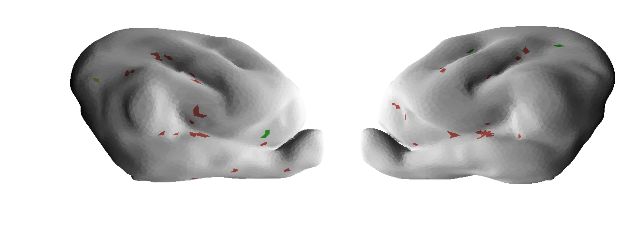

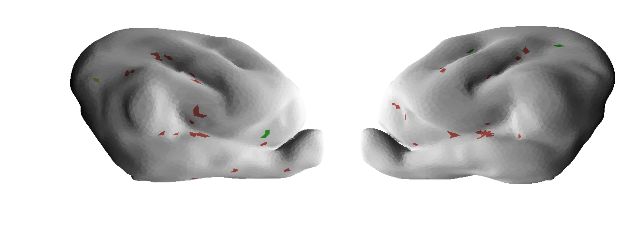

In [16]:
data = np.ones(mesh["np"])

sns.set_context('poster')
sns.set_style("white")

plot_surf.create_fig( coords=mesh["p"], faces=mesh["t"],  labels=pep, sulc=sulc, azims=[90, 270], elevs=[0, 0], cpal='hls', cbar=True, alpha=1)
#plt.savefig(path+'P16_F21_sulc_fig.png')

#plt.plot(endpoints[:,0],endpoints[:,1])


Annex

In [8]:
t=t.astype(dtype=np.int32)

from pyoctree import pyoctree as ot
tree = ot.PyOctree(p,t)

# Print out basic Octree data
print "Size of Octree               = %.3fmm" % tree.root.size
print "Number of Octnodes in Octree = %d" % tree.getNumberOfNodes()
print "Number of polys in Octree    = %d" % tree.numPolys

tree.getOctreeRep()

In [17]:
# get the selected nodes coordinates

nodes = np.zeros((len(endpoints),2))
nodes_coords = np.zeros((len(endpoints),3))

#create tree
t=t.astype(dtype=np.int32)

from pyoctree import pyoctree as ot
tree = ot.PyOctree(pt,t)

x=0
for ep in endpoints:
    nid, d = findClosestNode(ep,tree)
    
    nodes_coords[x] = tree.getNodeFromId(nid).position
    x+=1

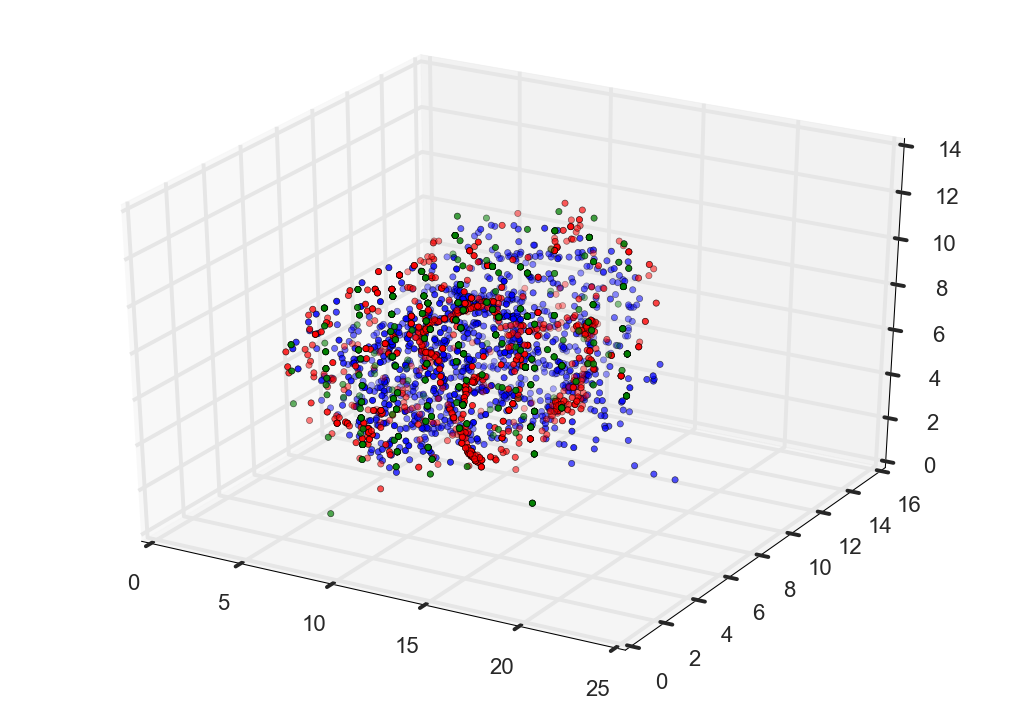

In [18]:
# rough check of the projected points positions compared to the initial endpoints and the nodes' positions 

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(points[:,0],points[:,1],points[:,2],c='r')
ax.scatter3D(endpoints[:,0],endpoints[:,1],endpoints[:,2])
ax.scatter3D(nodes_coords[:,0],nodes_coords[:,1],nodes_coords[:,2],c='g')

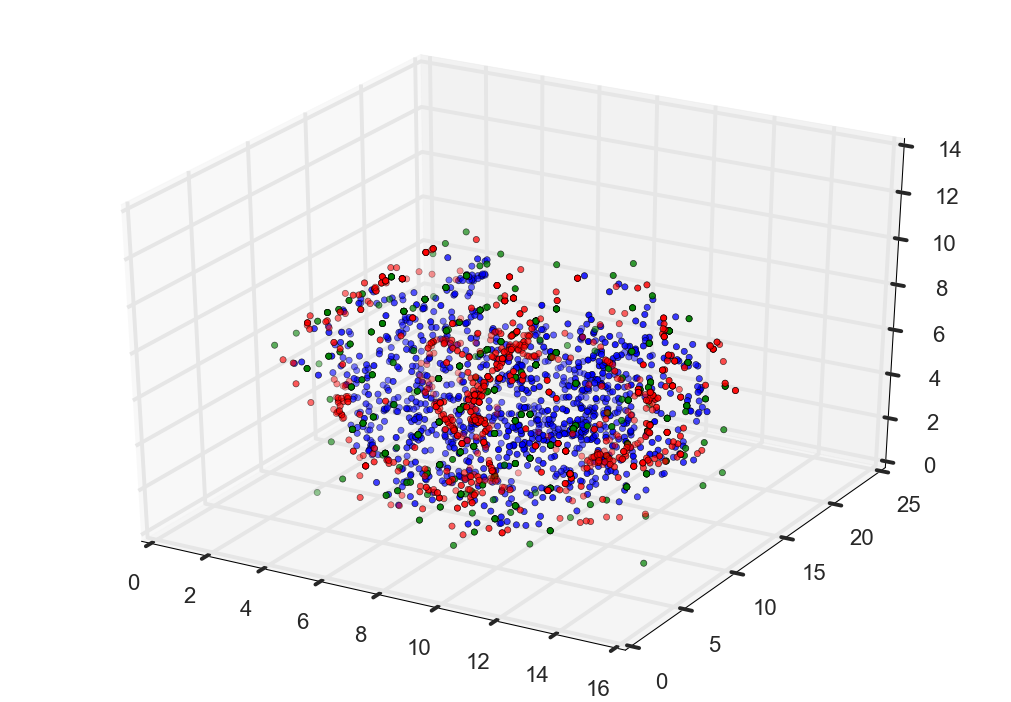

In [19]:
# rough check of the projected points positions compared to the initial endpoints and the nodes' positions 

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(points[:,1],points[:,0],points[:,2],c='r')
ax.scatter3D(endpoints[:,1],endpoints[:,0],endpoints[:,2])
ax.scatter3D(nodes_coords[:,1],nodes_coords[:,0],nodes_coords[:,2],c='g')